# The Zillow Data Science Team wants to be able to predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August 2017.
  Additionally, information is needed outside of the model. Because property taxes are assessed at the county level, the team would like to know:
        * What states and counties these are located in?
        * What is the distribution of tax rates for each county?
  **Objectives for this project include:**
  * Identifying and finding the features/drivers for predicting home values using the tax assessed value.
  * Documenting process and analysis throughout the data science pipeline.
  * Constructing a regression model that predicts home values for Zillow.
  * Deliverables:
    - README.md file containing overall project information.
    - Jupyter Notebook Report detailing the pipeline process.
    - Report/presentation slides that summarize findings about the drivers of the single unit property values.
    - Python file that houses functions to acquire and prepare data.


## Hypothesis:
    - Is there a correlation between square footage of a home and its tax value?
    - Is there a difference in tax value for homes based on counties? 

In [1]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#acquires and preps data
import wrangle

#split and scale functions
from sklearn.model_selection import train_test_split
from wrangle import Min_Max_Scaler

#statistical testing
from scipy import stats

# evaluating/modeling methods
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#Modeling Functions for later 
def residuals(actual, predicted):
    return actual - predicted

def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def evaluation_metrics_mean(actual):
    predicted = actual.mean()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

def evaluation_metrics_median(actual):
    predicted = actual.median()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

# Acquire Data

In [3]:
zillow = wrangle.get_zillow_data()

In [4]:
zillow.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [5]:
#Summarize 

In [6]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38622 entries, 0 to 38621
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38622 non-null  int64  
 1   id                            38622 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38622 non-null  float64
 6   bedroomcnt                    38622 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38463 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38509 non-null  float64
 13  f

In [7]:
zillow.describe()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,logerror
count,3.862200e+04,3.862200e+04,12224.000000,101.000000,27.000000,38622.000000,38622.000000,23706.000000,38463.000000,333.0,...,84.0,3.857000e+04,3.862100e+04,38622.0,3.862100e+04,38621.000000,1268.000000,3.847800e+04,38622.000000,38622.000000
mean,1.310495e+07,1.500394e+06,1.900196,7.564356,639.703704,2.273743,3.010512,6.610394,2.282739,66.0,...,1.0,1.907161e+05,4.965779e+05,2016.0,3.061136e+05,6042.953623,14.070978,6.050206e+13,52116.933794,0.015917
std,3.700741e+06,8.591808e+05,3.112632,3.232386,445.977907,0.950588,1.029506,1.694360,0.941702,0.0,...,0.0,2.384221e+05,6.326909e+05,0.0,4.583442e+05,7366.777380,1.482764,2.126099e+11,12046.770714,0.172150
min,1.071186e+07,3.490000e+02,1.000000,2.000000,100.000000,0.000000,0.000000,1.000000,1.000000,66.0,...,1.0,1.290000e+02,1.000000e+03,2016.0,1.000000e+03,19.920000,7.000000,6.037101e+13,625.000000,-4.453964
25%,1.154805e+07,7.599932e+05,1.000000,7.000000,349.000000,2.000000,2.000000,6.000000,2.000000,66.0,...,1.0,8.451250e+04,2.090510e+05,2016.0,8.702300e+04,2720.440000,14.000000,6.037400e+13,41836.250000,-0.023433
50%,1.260418e+07,1.507182e+06,1.000000,7.000000,604.000000,2.000000,3.000000,7.000000,2.000000,66.0,...,1.0,1.369250e+05,3.635160e+05,2016.0,2.080000e+05,4464.540000,15.000000,6.037651e+13,52156.500000,0.006802
75%,1.429905e+07,2.242966e+06,1.000000,7.000000,743.000000,3.000000,4.000000,8.000000,3.000000,66.0,...,1.0,2.199940e+05,5.778040e+05,2016.0,3.761050e+05,6984.240000,15.000000,6.059052e+13,62495.750000,0.037605
max,1.676878e+08,2.982274e+06,13.000000,21.000000,1969.000000,11.000000,12.000000,12.000000,11.000000,66.0,...,1.0,1.142179e+07,2.385837e+07,2016.0,1.635060e+07,276797.830000,15.000000,6.111009e+13,72844.000000,3.175688


In [8]:
print(f'My original dataframe is coming in with {zillow.shape[0]} rows and {zillow.shape[1]} columns.')

My original dataframe is coming in with 38622 rows and 62 columns.


In [9]:
#Nulls
zillow.isnull().sum()

parcelid                        0
id                              0
airconditioningtypeid       26398
architecturalstyletypeid    38521
basementsqft                38595
                            ...  
taxdelinquencyyear          37354
censustractandblock           144
id                              0
logerror                        0
transactiondate                 0
Length: 62, dtype: int64

In [10]:
sum_features = zillow[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]

sum_features.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,38622.0,3.010512,1.029506,0.0,2.0,3.0,4.0,12.0
bathroomcnt,38622.0,2.273743,0.950588,0.0,2.0,2.0,3.0,11.0
calculatedfinishedsquarefeet,38509.0,1762.746709,928.300281,240.0,1174.0,1525.0,2082.0,17245.0
taxvaluedollarcnt,38621.0,496577.879651,632690.906146,1000.0,209051.0,363516.0,577804.0,23858374.0


Text(0.5, 1.0, 'Distribution of tax value')

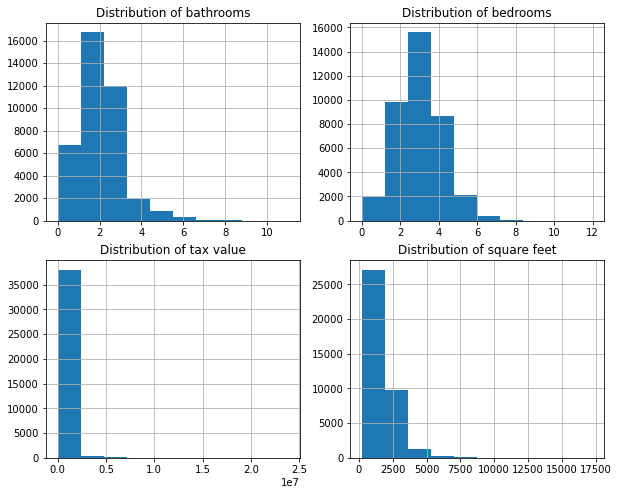

In [11]:
# use subplots to view distribution of numeric columns
plt.figure(figsize=(10, 8))

plt.subplot(222)
zillow.bedroomcnt.hist()
plt.gca().set_title('Distribution of bedrooms')

plt.subplot(221)
zillow.bathroomcnt.hist()
plt.gca().set_title('Distribution of bathrooms')


plt.subplot(224)
zillow.calculatedfinishedsquarefeet.hist()
plt.gca().set_title('Distribution of square feet')

plt.subplot(223)
zillow.taxvaluedollarcnt.hist() 
plt.gca().set_title('Distribution of tax value')


** Takeaways** :
- There are alot of nulls in this data, that I will need to remove, as well as redundant columns to address.
- Need to rename certain columns
- Data requires cleaning, and scaling/

# Preparation of Data

In [12]:
zillow_prep = wrangle.clean_zillow(zillow)
zillow_prep.head()

,bedrooms,bathrooms,square_feet,county_fips,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,
14634203,3,2.0,1125,6059,43,289445,3490.16,1.21
11721753,3,2.0,1316,6037,94,205123,2627.48,1.28
11289917,3,2.0,1458,6037,47,136104,2319.90,1.70
11637029,3,2.0,1766,6037,37,810694,9407.01,1.16
11705026,2,1.0,1421,6037,106,35606,543.69,1.53


In [13]:
zillow_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34837 entries, 14634203 to 10713993
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     34837 non-null  int64  
 1   bathrooms    34837 non-null  float64
 2   square_feet  34837 non-null  int64  
 3   county_fips  34837 non-null  int64  
 4   age          34837 non-null  int64  
 5   tax_value    34837 non-null  int64  
 6   taxes        34837 non-null  float64
 7   tax_rate     34837 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.4 MB


In [14]:
#Check nulls
zillow_prep.isnull().sum()

bedrooms       0
bathrooms      0
square_feet    0
county_fips    0
age            0
tax_value      0
taxes          0
tax_rate       0
dtype: int64

In [15]:
#Drop 'taxes' and 'tax_rate'
zillow = zillow_prep.drop(columns=['taxes', 'tax_rate'])

In [16]:
zillow.head()

,bedrooms,bathrooms,square_feet,county_fips,age,tax_value
parcelid,,,,,,
14634203,3,2.0,1125,6059,43,289445
11721753,3,2.0,1316,6037,94,205123
11289917,3,2.0,1458,6037,47,136104
11637029,3,2.0,1766,6037,37,810694
11705026,2,1.0,1421,6037,106,35606


In [17]:
#Split the data
train, validate, test = wrangle.split(zillow)

In [18]:
#check split datasets
print('overall shape of dataframe:', zillow.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

overall shape of dataframe: (34837, 6)
train: (19508, 6)
validate: (8361, 6)
test: (6968, 6)


In [19]:
train.head()

,bedrooms,bathrooms,square_feet,county_fips,age,tax_value
parcelid,,,,,,
10712731,3,2.0,1962,6037,54,86942
17139143,2,2.0,1070,6111,39,78600
12488599,2,1.0,1132,6037,75,228724
14308150,2,2.0,1208,6059,37,698413
14444150,3,2.0,1855,6059,52,301297


In [20]:
# Xand Y 
X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [21]:
#Min_Max_Scaler
X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [22]:
#Peek at X_train
X_train_scaled.head()

,bedrooms,bathrooms,square_feet,county_fips,age
parcelid,,,,,
10712731,0.333333,0.266667,0.537957,0.000000,0.404580
17139143,0.222222,0.266667,0.259294,1.000000,0.290076
12488599,0.222222,0.133333,0.278663,0.000000,0.564885
14308150,0.222222,0.266667,0.302405,0.297297,0.274809
14444150,0.333333,0.266667,0.504530,0.297297,0.389313


# Takeaways here
- Data is now cleaned and prepped.
    - Also split into trrian, test and validate.
- I specified features I plan to focus on in my explortion and modeling phase.
- Scaled data for modeling and evaluationm


# Data Exploration


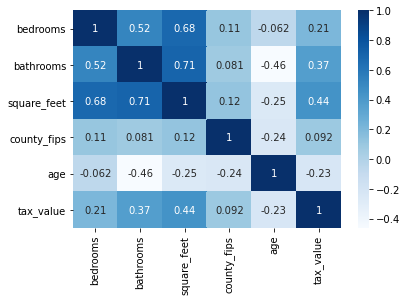

In [23]:
#Heatmap to examine correlation 
sns.heatmap(train.corr(), cmap='Blues', annot=True)

plt.show()

## Findings 
- There appears to be significant correltion between tax_value and square_feet
- tax_value shows negative correlation with age

In [24]:
def plot_variable_pairs(train):
    '''
    This function will accept a dataframe as input 
    and plot all the pairwise relationships with the regression line for each pair
    '''
    sns.pairplot(train, 
                kind = "reg", 
                plot_kws = {'line_kws': {'color': 'crimson'}})

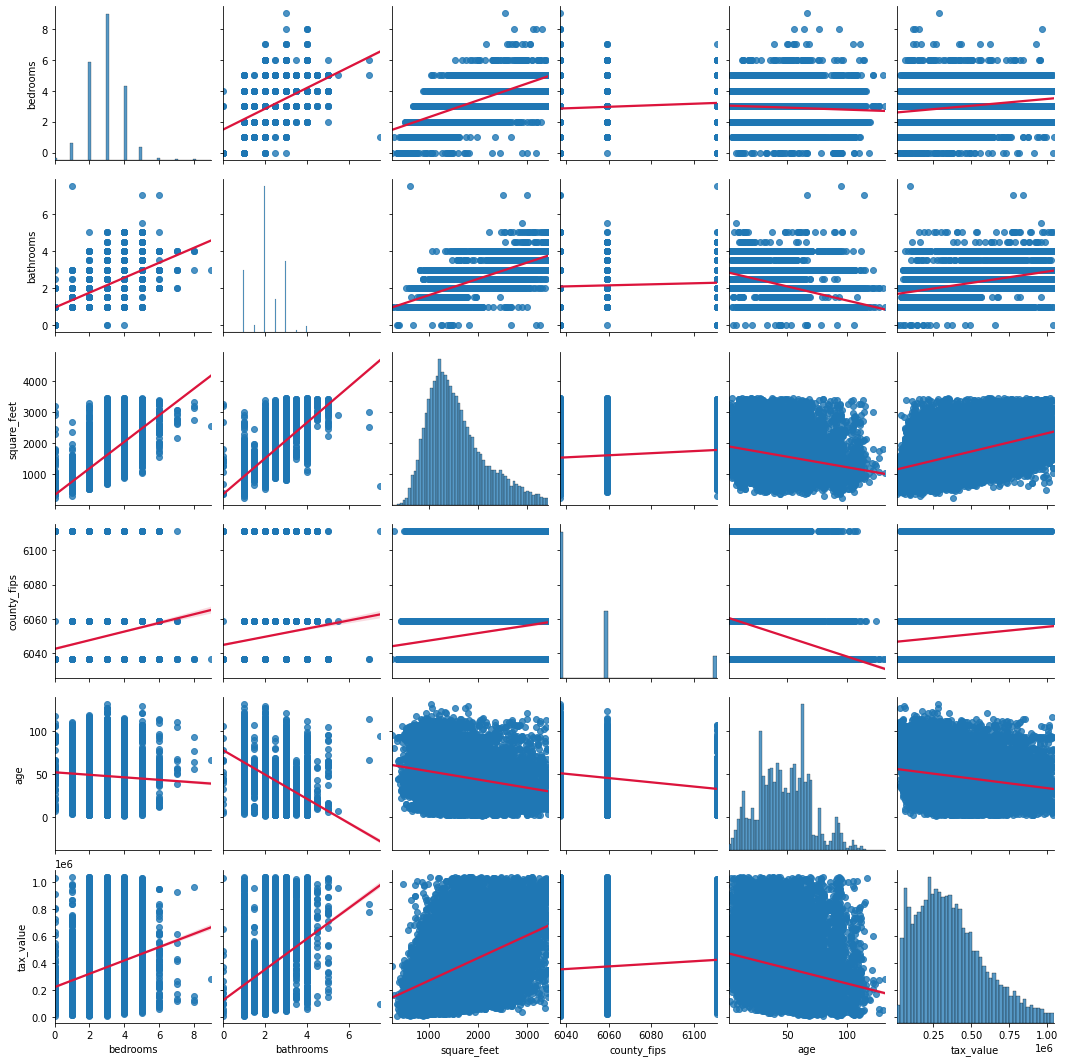

In [25]:
plot_variable_pairs(train)

In [26]:
## Findings 

In [27]:
#Determine the states/ counties the properties are located in


In [28]:
# 6037 - Los Angeles
# 6059 - Orange county
# 6111 - Ventura 
hot_month_counties = pd.DataFrame({'county_fips': [6037, 6059, 6111],
                       'County': ['Los Angeles', 'Orange', 'Ventura']})
hot_month_counties.head()

,county_fips,County
0,6037,Los Angeles
1,6059,Orange
2,6111,Ventura


In [29]:
#Counties and square footage relationship  based on county 

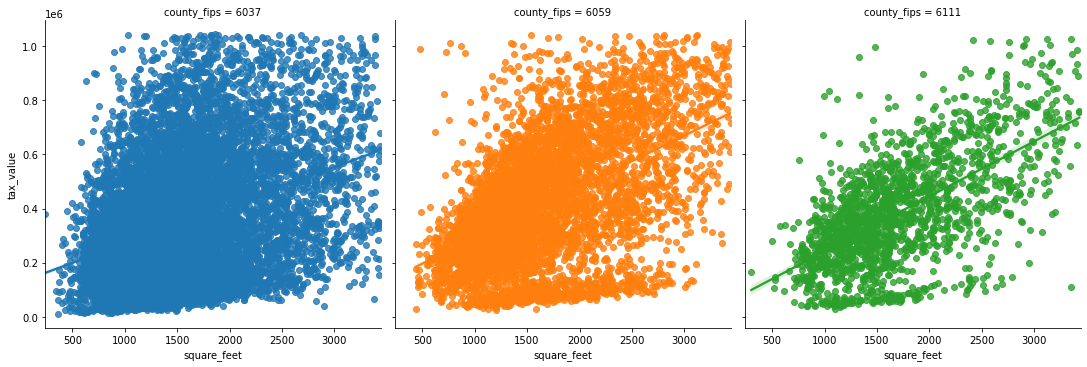

In [30]:
sns.lmplot(data=train, 
           x='square_feet', 
           y='tax_value', 
           hue = 'county_fips', 
           col = 'county_fips', 
           col_wrap=3)

plt.show()

##  Findings 
- The more square footage, the higher the tax value

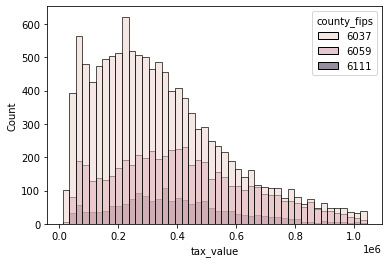

In [31]:
sns.histplot(data=train, x="tax_value", hue="county_fips")
plt.show()

## Takeaways
- Highest tax values found in Los Angeles county
- Orange County is the middle(6059).
- Lowest tax value found in ventura county


# Statistical Testing

In [32]:
#Tax Value x Square Feet Corre;ation Test
null_hypothesis = "There is NO correlation between tax value and square footage of a home."
alternative_hypothesis = "There is a correlation between tax value and square footage of a home."
confidence_level = .95
alpha = 1 - confidence_level

corr, p = stats.pearsonr(train.square_feet, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

We reject the null hypothesis.
We can move forward with the alternative hypothesis: There is a correlation between tax value and square footage of a home.


In [33]:
# Tax Value x Counties
null_hypothesis = "There is NO difference in tax value between Los Angeles county and the rest of the counties."
alternative_hypothesis = "There is a difference in tax value between Los Angeles county and other counties."
confidence_level = .95
alpha = 1 - confidence_level

los_angeles_county = train[train.county_fips  == 6037].tax_value
counties_other_than_los_angeles = train[train.county_fips != 6037].tax_value

t, p = stats.ttest_ind(los_angeles_county, counties_other_than_los_angeles)


if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)

else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

We reject the null hypothesis.
We can move forward with the alternative hypothesis: There is a difference in tax value between Los Angeles county and other counties.


# Takeaways
- Statistical testing showed me that :
    -There is a correlation between tax value and square footage of a home.
    -There is a difference in tax value between Los Angeles county and counties other than Los Angeles.

## Data Modeling 

In [34]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict mean of tax_value
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#Compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median


In [35]:
#Use the mean to evaluate baseline model
evaluation_metrics_mean(y_train.tax_value)

{'sse': 983333176058051.1,
 'mse': 50406662705.456795,
 'rmse': 224514.28174050932}

## Takeaways
- Will use the mean for my baseline
- Moving forward with RMSE as it had a signifigantly lower value than my other models.


In [36]:
#Findings go here
#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  224514.28 
Validate/Out-of-Sample:  226126.54


# OLS Model

In [37]:

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)


# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)


# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  197577.5911323664 
Validation/Out-of-Sample:  196723.3937824227


# LassoLars

In [38]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  197577.5911323664 
Validation/Out-of-Sample:  196723.3937824227


# TweedieRegressor (GLM)

In [39]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  198021.02299148266 
Validation/Out-of-Sample:  198021.02299148266


# Polynomial Regression

In [40]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  197577.5911323664 
Validation/Out-of-Sample:  38700093661.27415


## Takeaways 
- My OLSs performed the best overall, the GLM performed well but will choose the OLS model as my top.
- My Polynomial Model did not perform better than my baseline.
- Will move forward with OLS model

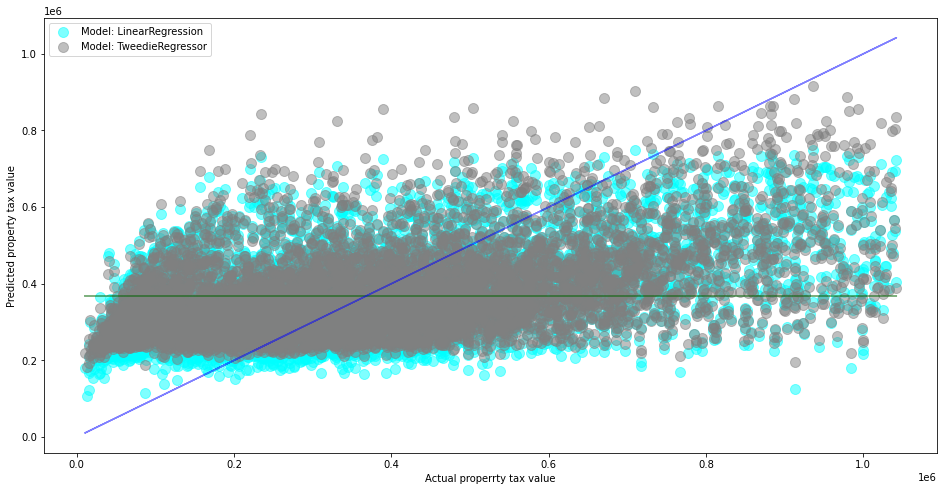

In [50]:
#plotting actual vs predicted values
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="darkgreen", label='_nolegend_')

plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="cyan", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="gray", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual property tax value")
plt.ylabel("Predicted property tax value")

plt.show()


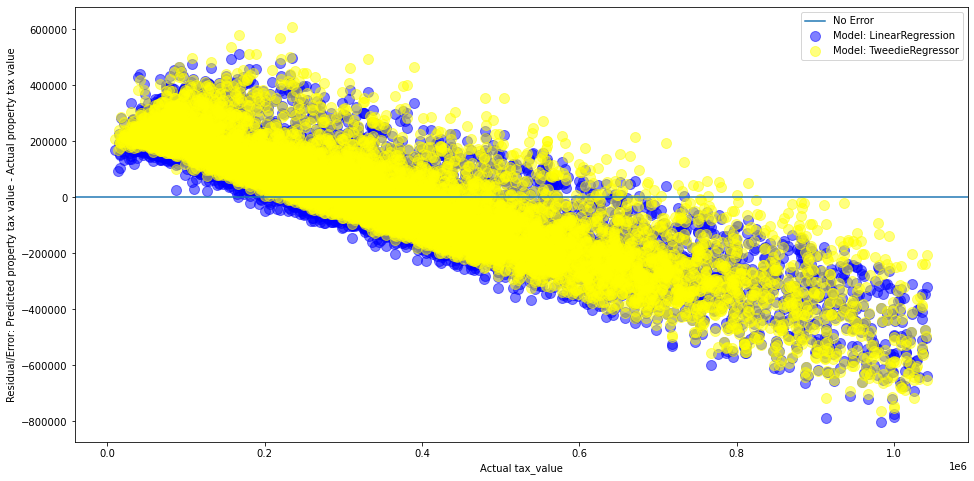

In [42]:
#residual plots: plotting the errors in predictions
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value, 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual tax_value")
plt.ylabel("Residual/Error: Predicted property tax value - Actual property tax value")

plt.show()

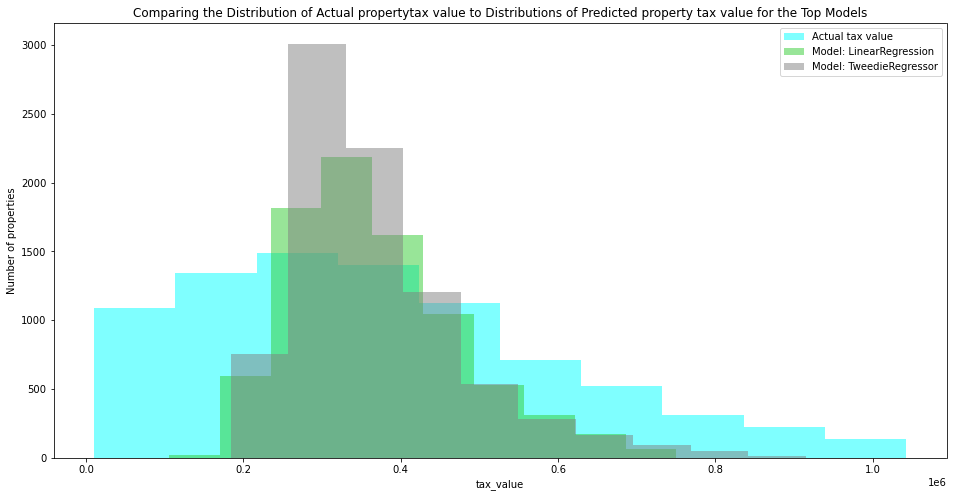

In [57]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tax_value, color='cyan', alpha=.5, label="Actual tax value")
plt.hist(y_validate.tax_value_pred_lm, color='limegreen', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='gray', alpha=.5, label="Model: TweedieRegressor")

plt.xlabel("tax_value")
plt.ylabel("Number of properties")
plt.title("Comparing the Distribution of Actual propertytax value to Distributions of Predicted property tax value for the Top Models")
plt.legend()
plt.show()


## Findings
- My Linear regression model performed best overall and will move forward with that as my best model.

In [44]:
#out of sample evaluation
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  196823.85747953743
